In [1]:
%pylab inline
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_pickle('../data/kal_returnsDF.pkl')
symbolsDF = pd.read_pickle('../data/symbolsDF.pkl')
sectors = symbolsDF.sector.unique().tolist()

In [3]:
start, end = '2007-05-02', '2016-04-11'                        #variable here
datadir_name = '_'.join(('data', start, end))
datadir_path = ''.join(('../data/', datadir_name))

In [12]:
def get_symbol_results(symbol='GS'):
    df = pd.read_pickle(''.join((datadir_path, '/', symbol, '.pkl')))
    return df
df = get_symbol_results()

* Develop a tear sheet where you can see p&l aligned with the actual price history and the kalman filter. This might give us ideas on what more to filter
* Only put on a trade when the residual is coming back from a max over a certain threshold.
* Only put on a trade when the overall smoothed function is moving on the same direction as the trade.
* Try different kalman filter parameter - see the sensitivity
* apply kalman filter trade logic to spread prices
* Try to apply splines to the spread prices

# tear sheet

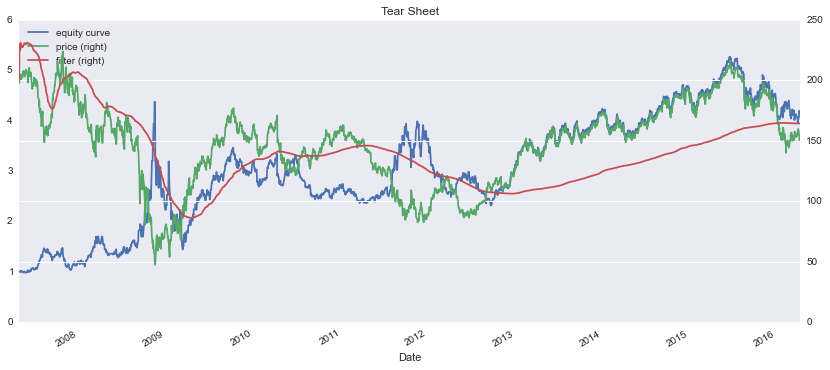

In [13]:
# tear sheet
np.cumprod(df.kal_returns+1).plot(label="equity curve", legend=True, 
                                  title='Tear Sheet', figsize=(14,6))
df['Adj Close'].plot(secondary_y=True, label="price", legend=True)
df.kalman_predict.plot(secondary_y=True, label="filter", legend=True)

# Only put on a trade when the residual is coming back from a max over a certain threshold.

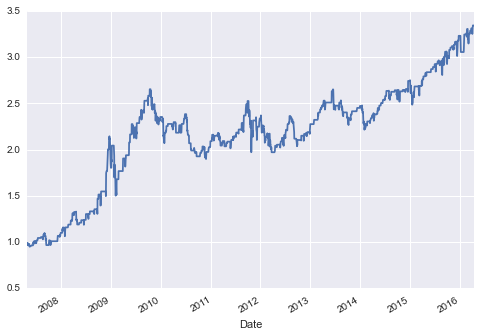

In [17]:
# fn from trade_logic (modified)
def get_historical_positions_old(df, smoothcol, pos_colname, days_returning=1):
    df['resids'] = df['Adj Close']-df[smoothcol]
    df[pos_colname] = ((df['resids']>0)-.5)*2
    df.loc[df['resids'].isnull(), pos_colname] = 0
    df.loc[((df['resids']==pd.rolling_max(df['resids'], 5)).astype(int) + 
          (df['resids']>0).astype(int))==2, pos_colname]=0
    df.loc[((df['resids']==pd.rolling_min(df['resids'], 5)).astype(int) + 
          (df['resids']<0).astype(int))==2, pos_colname]=0
    while days_returning>1:
        df.loc[df[pos_colname].shift(1)==0, pos_colname]=0
        days_returning -= 1
    return df

df = get_historical_positions_old(df, smoothcol= 'kalman_predict', 
                                  pos_colname = 'kal_oldlogic_pos', days_returning=4)

df['kal_oldlogic_return']= df['daily_rets']*df['kal_oldlogic_pos']

np.cumprod(df.kal_oldlogic_return+1).plot()

In [ ]:
# test out 

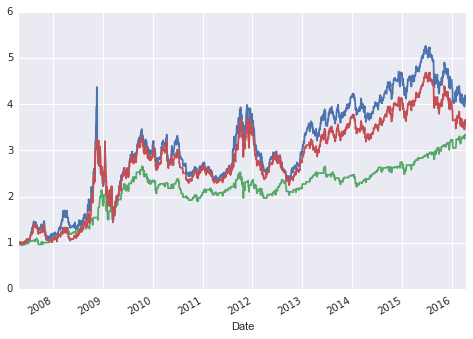

In [140]:
np.cumprod(df.kal_returns+1).plot()
np.cumprod(df.kal_oldlogic_return+1).plot()
df.loc[df['kal_returns'].shift(1)==0, 'kal_returns']=0
np.cumprod(df.kal_returns+1).plot()


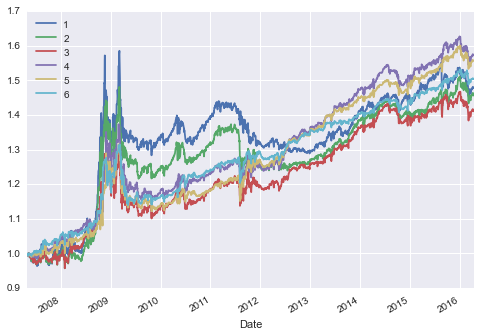

In [18]:
for i in range(6):
    bigDF = pd.DataFrame()
    for symbol in symbolsDF.index:
        df = get_symbol_results(symbol)
        bigDF[symbol] = get_historical_positions_old(df, smoothcol= 'kalman_predict', 
                pos_colname = 'kal_oldlogic_pos', 
                days_returning=i+1).kal_oldlogic_pos * df.daily_rets
    np.cumprod(bigDF.mean(axis=1)+1).plot(label=i+1, legend=True)

WLTW


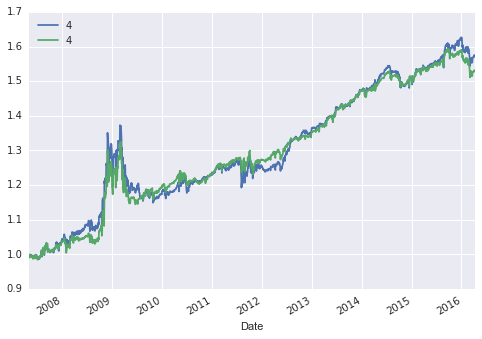

In [164]:
for i in [3]:
    bigDF = pd.DataFrame()
    for symbol in symbolsDF.index:
        df = get_symbol_results(symbol)
        bigDF[symbol] = get_historical_positions_old(df, smoothcol= 'kalman_predict', 
                pos_colname = 'kal_oldlogic_pos', 
                days_returning=i+1).kal_oldlogic_pos * df.daily_rets
    np.cumprod(bigDF.mean(axis=1)+1).plot(label=i+1, legend=True)
    
for i in [3]:
    bigDF = pd.DataFrame()
    for symbol in symbolsDF.index:
        df = get_symbol_results(symbol)
        df = get_historical_positions_old(df, smoothcol= 'kalman_predict', 
                pos_colname = 'kal_oldlogic_pos', 
                days_returning=i+1)
        try:
            bigDF[symbol] = limit_by_direction(df, 'kal_oldlogic_pos', 
                                           'smooth_slope_100').kal_oldlogic_pos * df.daily_rets
        except:
            print(symbol)
    np.cumprod(bigDF.mean(axis=1)+1).plot(label=i+1, legend=True)

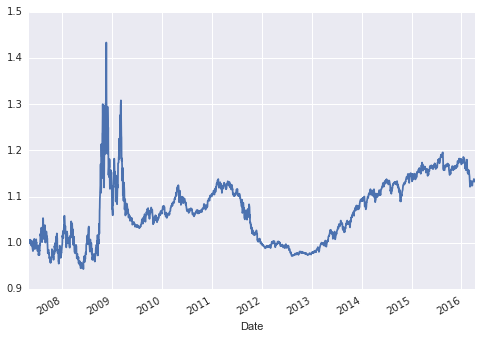

In [148]:
bigDF = pd.DataFrame()
for symbol in symbolsDF.index:
    df = get_symbol_results(symbol)
    bigDF[symbol] = df.kal_returns
np.cumprod(bigDF.mean(axis=1)+1).plot()

In [180]:
sp = pd.read_csv('/Users/liamconnell/Downloads/HistoricalSP500.csv')
symbols_2008 = sp[sp['2008'] == 'X'].Ticker.tolist()

In [ ]:
start, end = '2007-05-02', '2016-04-11' 
import pandas.io.data as web
for symbol in symbols_2008:
    try:
        df = web.DataReader(symbol, 'yahoo', start, end)
    except:
        print(symbol)

AGN (Old)
AIV
AMP
AMZN
ANF
AON
APC
APOL
AW

In [8]:
symbol = 'GS'
import pandas.io.data as web
df = web.DataReader(symbol, 'yahoo', start, end)


In [7]:
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2007-05-02,218.000000,221.919998,217.449997,219.490005,4859500,197.556542
2007-05-03,220.389999,221.929993,218.550003,221.559998,4414600,199.419681
2007-05-04,222.600006,227.339996,221.429993,227.339996,5632300,204.622089
2007-05-07,227.000000,229.899994,225.600006,227.220001,4637000,204.514085
2007-05-08,225.919998,225.990005,222.960007,224.949997,4879700,202.470921


telecommunications_services


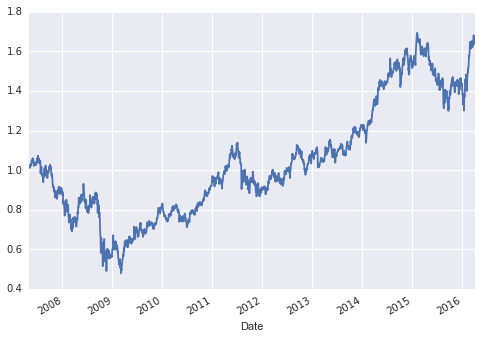

energy


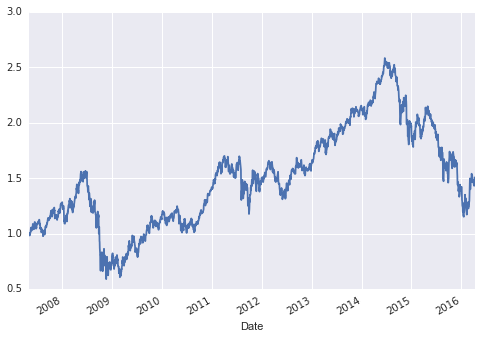

information_technology


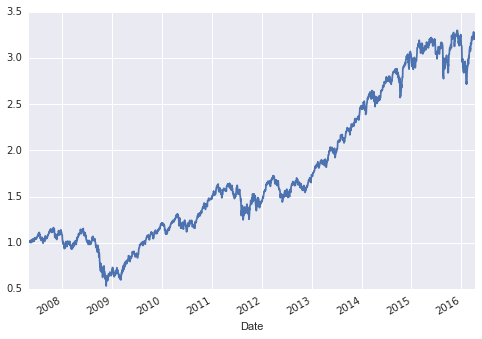

utilities


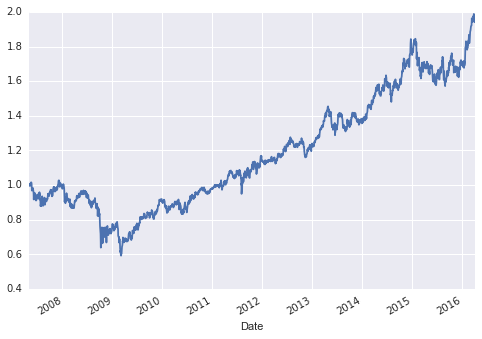

materials


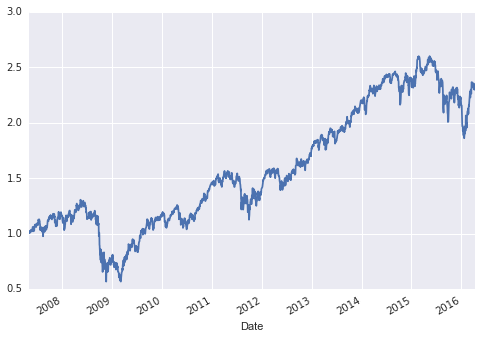

consumer_staples


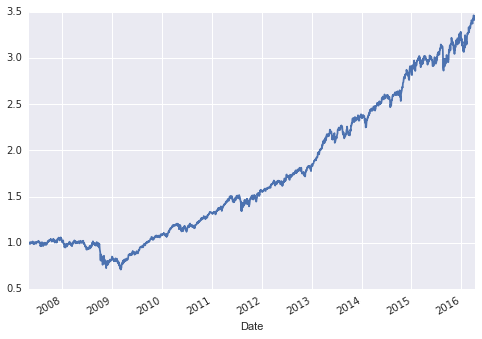

financials


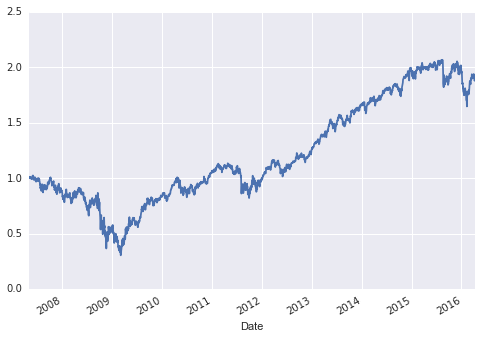

health_care


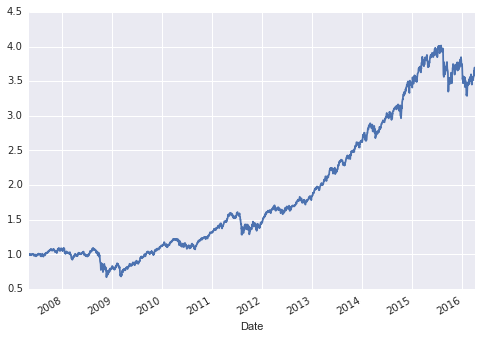

industrials


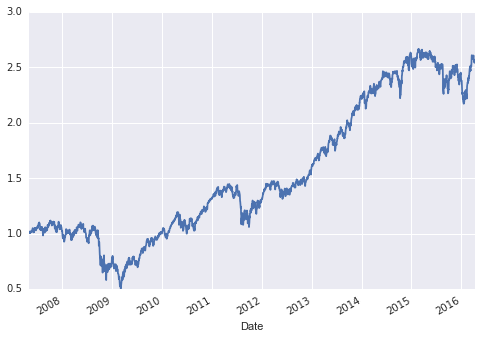

consumer_discretionary


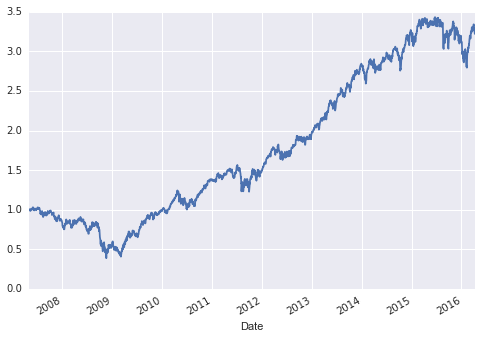

In [171]:
for sector_ in sectors:
    print(sector_)
    syms = symbolsDF[symbolsDF.sector == sector_].symbols
    bigDF = pd.DataFrame()
    for symbol in syms:
        df = get_symbol_results(symbol)
        bigDF[symbol] = df.daily_rets
    np.cumprod(bigDF.mean(axis=1)+1).plot()
    show()

# Only put on a trade when the overall smoothed function is moving on the same direction as the trade.

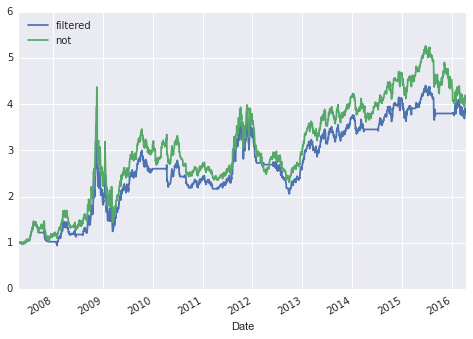

In [131]:
def limit_by_direction(df, poscol, slopecol):
    df.loc[((df.kal_pos>0).astype(int)!=(df.smooth_slope_100>0).astype(int)), poscol] = 0
    return df
df = limit_by_direction(df, 'kal_pos', 'smooth_slope_100')

df['kal_filter_return']= df['daily_rets']*df['kal_pos']

np.cumprod(df.kal_filter_return+1).plot(label="filtered", legend=True)
np.cumprod(df.kal_returns+1).plot(label="not", legend=True)

WLTW


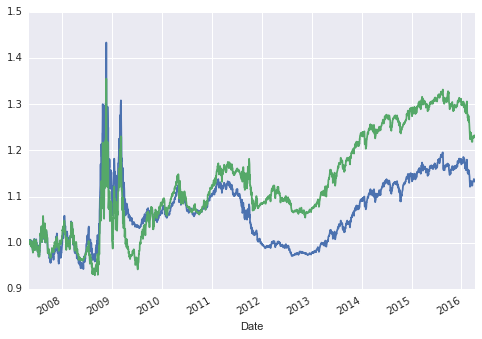

In [158]:
bigDF = pd.DataFrame()
for symbol in symbolsDF.index:
    df = get_symbol_results(symbol)
    bigDF[symbol] = df.kal_returns
np.cumprod(bigDF.mean(axis=1)+1).plot()

bigDF = pd.DataFrame()
for symbol in symbolsDF.index:
    df = get_symbol_results(symbol)
    try:
        bigDF[symbol] = limit_by_direction(df, 'kal_pos', 
                                           'smooth_slope_100').kal_pos * df.daily_rets
    except:
        print(symbol)
np.cumprod(bigDF.mean(axis=1)+1).plot()

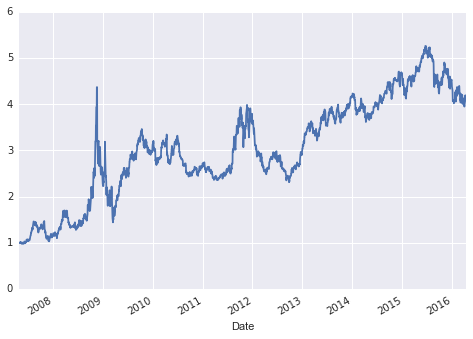

In [128]:
df['kal_returns']= df['daily_rets']*df['kal_pos']
np.cumprod(df.kal_returns+1).plot()

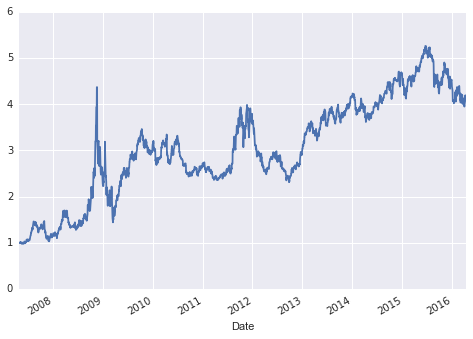

In [127]:
np.cumprod(df.kal_returns+1).plot()

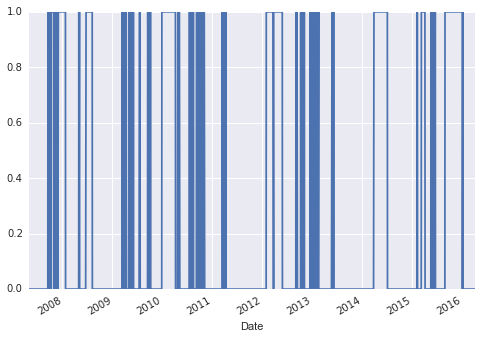

In [121]:
((df.kal_pos>0).astype(int)!=(df.smooth_slope_100>0).astype(int)).plot()
#(df.kalman_slope>0).astype(int).plot()
#(df.smooth_slope_100>0).plot()